In [1]:
import os
import sys
import wandb
import torch
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from segmentation_models_pytorch import Unet
from collections import OrderedDict
from torch.utils.data import DataLoader
from lightning.pytorch import Trainer
from sklearn.metrics import roc_auc_score, roc_curve, auc

sys.path.append("../scripts/")
from asm_datamodules import *
from asm_models import *

In [2]:
%load_ext autoreload
%autoreload 2

# Download result from WandB

In [8]:
split_id = "670487"

In [9]:
run = wandb.init()
artifact = run.use_artifact('asm_detect/ASM_seg_global/model-svm9dtl3:v0', type='model')

root = f"/n/home07/kayan/asm/models/global_{split_id}"
artifact_dir = artifact.download(root=root)
wandb.finish()

wandb: Downloading large artifact model-svm9dtl3:v0, 164.20MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


# Load model

In [4]:
# same parameters as trained model
backbone = "resnet18"
weights = True
in_channels=4
num_classes=2

In [10]:
artifact_dir = f"/n/home07/kayan/asm/models/global_{split_id}"
# create new version of state dict with keys matching unet model
state_dict = torch.load(f"{artifact_dir}/model.ckpt")["state_dict"]
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k[:5] == "model":
        name = k[6:] # remove `model.`
        new_state_dict[name] = v

# load model
model = Unet(encoder_name=backbone,
            encoder_weights="imagenet" if weights is True else None,
            in_channels=in_channels,
            classes=num_classes,
            )
model.load_state_dict(new_state_dict)

<All keys matched successfully>

# Run inference

In [6]:
# device configuration
device, num_devices = ("cuda", torch.cuda.device_count()) if torch.cuda.is_available() else ("cpu", len(os.sched_getaffinity(0)))
workers = len(os.sched_getaffinity(0))
print(f"Running on {num_devices} {device}(s) with {workers} cpus")

Running on 1 cuda(s) with 4 cpus


In [11]:
# datamodule parameters
root = "/n/holyscratch01/tambe_lab/kayan/karena/"
batch_size = 64
num_workers = workers
mines_only = False
split = False
split_n = None
save_split = False
split_path = f"/n/home07/kayan/asm/data/splits/split_{split_id}"

In [12]:
# get test dataloader from datamodule
datamodule = ASMDataModule(batch_size=batch_size, num_workers=num_workers, split=split, split_n=split_n, 
                           root=root, transforms=min_max_transform, mines_only=mines_only, split_path=split_path)
datamodule.setup("test")
test_dataloader = datamodule.test_dataloader()

# Put model on evaluation mode and load to local device
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

pixelwise_predictions = {}
image_predictions = {}

with torch.inference_mode():
    for idx,samples in enumerate(test_dataloader):
        unique_ids = samples['id']

        # Move input data to the device
        inputs = samples['image'].to(device)

        # Forward pass
        outputs = model(inputs)
        outputs = torch.softmax(outputs, dim=1)

        for unique_id,output in zip(unique_ids, outputs):
            preds = output[1].cpu().numpy()
            pixelwise_predictions[unique_id] = preds
            image_predictions[unique_id] = np.mean(preds)

        if idx%5==0: print(f"Batch {idx}", end=" ")

Batch 0 Batch 5 Batch 10 Batch 15 Batch 20 Batch 25 Batch 30 Batch 35 Batch 40 Batch 45 

# Analyze test results by country

In [13]:
# true label data
path="/n/home07/kayan/asm/data/filtered_labels.geojson"
label_df = gpd.read_file(path)

In [38]:
def country_roc_auc(image_preds, label_df, key):
    '''Given image-wide predictions, calculate AUC and plot ROC curve for country of interest'''
    country_df = label_df[label_df["country"]==key]
    # remove any rows that don't have a corresponding image in test set
    country_df = country_df[country_df["unique_id"].isin(image_preds.keys())]
    
    class_proba = [image_preds[unique_id] for unique_id in country_df["unique_id"]]
    true_labels = country_df["label"].values
    
    fig,ax = plt.subplots()
    fpr, tpr, _ = roc_curve(true_labels, class_proba)
    ax.plot(fpr, tpr)
    ax.set_title(f"LOCO test ROC for {key}")
    ax.set_xlabel("False Positive")
    ax.set_ylabel("True Positive")
    
    auc = roc_auc_score(true_labels, class_proba)
    print(f"LOCO test AUC for {key} is: {auc}")
    return auc

LOCO test AUC for SLE is: 0.8668722737186477
LOCO test AUC for COD is: 0.8338213672362456
LOCO test AUC for CAF is: 0.7981283422459893
LOCO test AUC for ZWE is: 0.7491496598639455
LOCO test AUC for TZA is: 0.7695358401880141


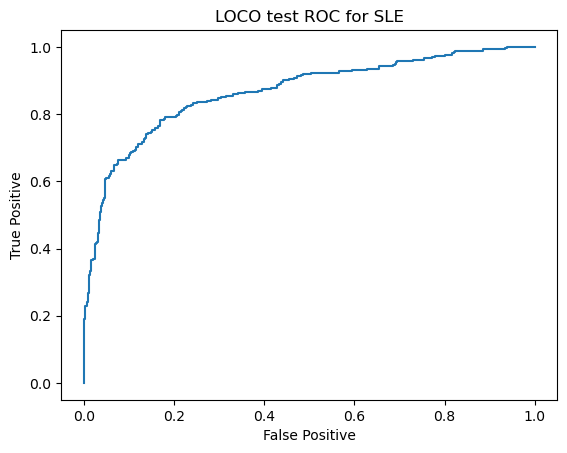

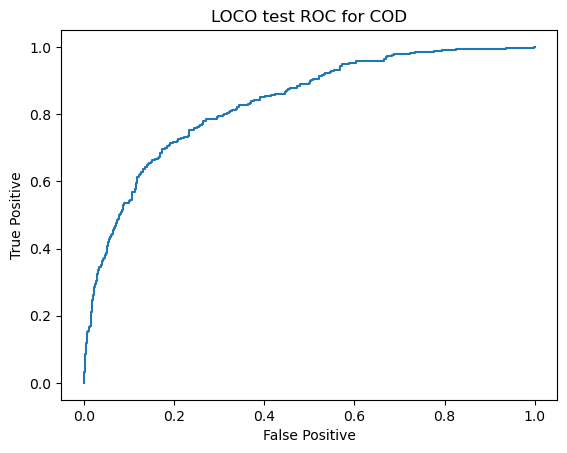

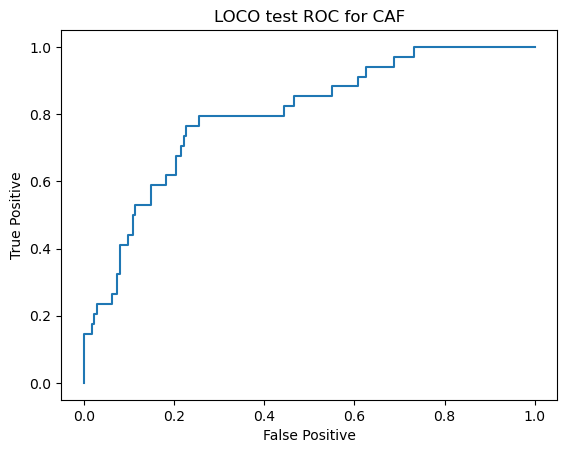

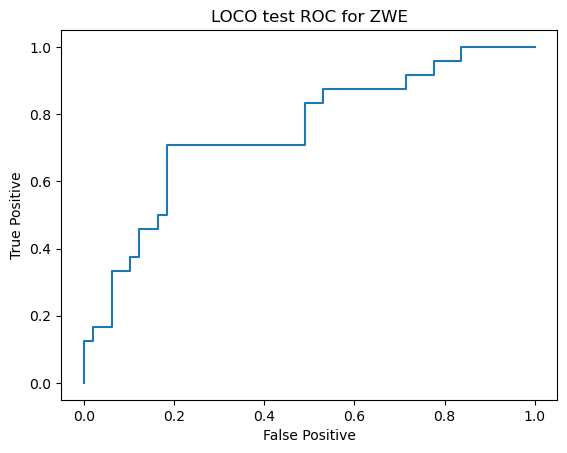

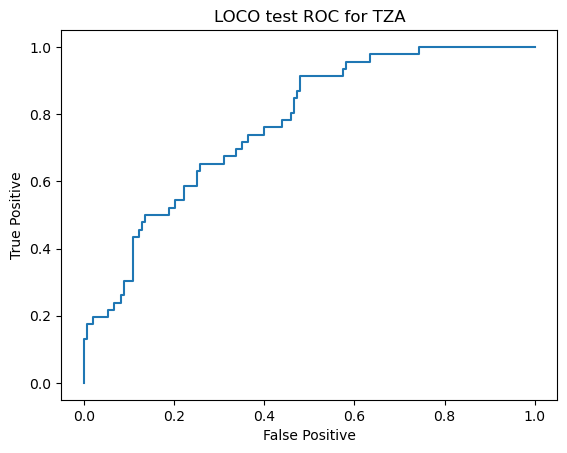

In [40]:
countries = ["SLE","COD","CAF","ZWE","TZA"]
global_AUC = {}

for key in countries:
    global_AUC[key] = country_roc_auc(image_predictions, label_df, key)

# Analyze overall test results

Global test AUC for all countries is: 0.8386681530350704


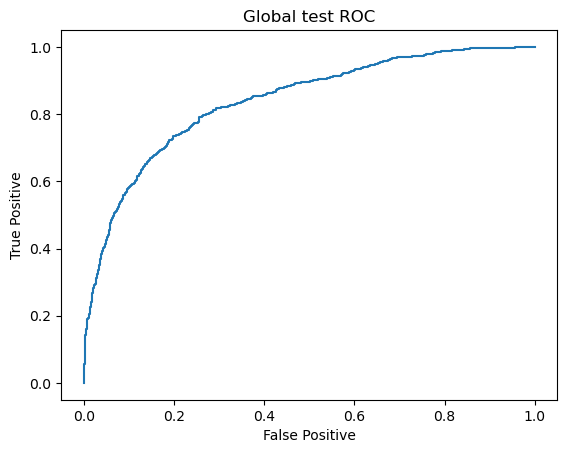

In [49]:
class_proba = image_predictions
true_labels = [label_df[label_df["unique_id"]==x]["label"].values[0] for x in class_proba.keys()]
class_proba = list(class_proba.values())

fig,ax = plt.subplots()
fpr, tpr, _ = roc_curve(true_labels, class_proba)
ax.plot(fpr, tpr)
ax.set_title(f"Global test ROC")
ax.set_xlabel("False Positive")
ax.set_ylabel("True Positive")

all_country_auc = roc_auc_score(true_labels, class_proba)
print(f"Global test AUC for all countries is: {all_country_auc}")

# Compare global and LOCO results

In [41]:
LOCO_AUC = {"SLE": 0.7688689580757294, "COD": 0.8249597746179436, "CAF": 0.8179005615221064,
           "ZWE": 0.6915458937198068, "TZA": 0.7522996020627075}

In [52]:
AUC_df = pd.DataFrame({"Global_AUC": global_AUC, "LOCO_AUC": LOCO_AUC})
AUC_df["Delta_AUC"] = AUC_df["Global_AUC"] - AUC_df["LOCO_AUC"]

In [53]:
AUC_df

,Global_AUC,LOCO_AUC,Delta_AUC
SLE,0.866872,0.768869,0.098003
COD,0.833821,0.824960,0.008862
CAF,0.798128,0.817901,-0.019772
ZWE,0.749150,0.691546,0.057604
TZA,0.769536,0.752300,0.017236


In [55]:
np.mean(AUC_df["Delta_AUC"])

0.0323865386509097